In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


Loading the dataset...

In [5]:
data = pd.read_csv('./AAPL.csv')
print(data.shape)
print(data.sample(7))


(2516, 7)
            Date       Open       High        Low      Close  Adj Close  \
1638  2016-07-07  23.924999  24.125000  23.905001  23.985001  22.087923   
2289  2019-02-07  43.099998  43.485001  42.584999  42.735001  41.017521   
1051  2014-03-10  18.870001  19.047501  18.869286  18.961430  16.722832   
1823  2017-03-31  35.930000  36.067501  35.752499  35.915001  33.569153   
751   2012-12-27  18.340714  18.437500  18.023571  18.395000  15.731544   
181   2010-09-22  10.096786  10.285000  10.086071  10.276786   8.711425   
1178  2014-09-09  24.770000  25.770000  24.035000  24.497499  21.834044   

         Volume  
1638  100558400  
2289  126966800  
1051  178584000  
1823   78646800  
751   455120400  
181   585289600  
1178  759385200  


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2516 non-null   object 
 1   Open       2516 non-null   float64
 2   High       2516 non-null   float64
 3   Low        2516 non-null   float64
 4   Close      2516 non-null   float64
 5   Adj Close  2516 non-null   float64
 6   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB


In [7]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2516 non-null   datetime64[ns]
 1   Open       2516 non-null   float64       
 2   High       2516 non-null   float64       
 3   Low        2516 non-null   float64       
 4   Close      2516 non-null   float64       
 5   Adj Close  2516 non-null   float64       
 6   Volume     2516 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 137.7 KB


Visualizaing the data...

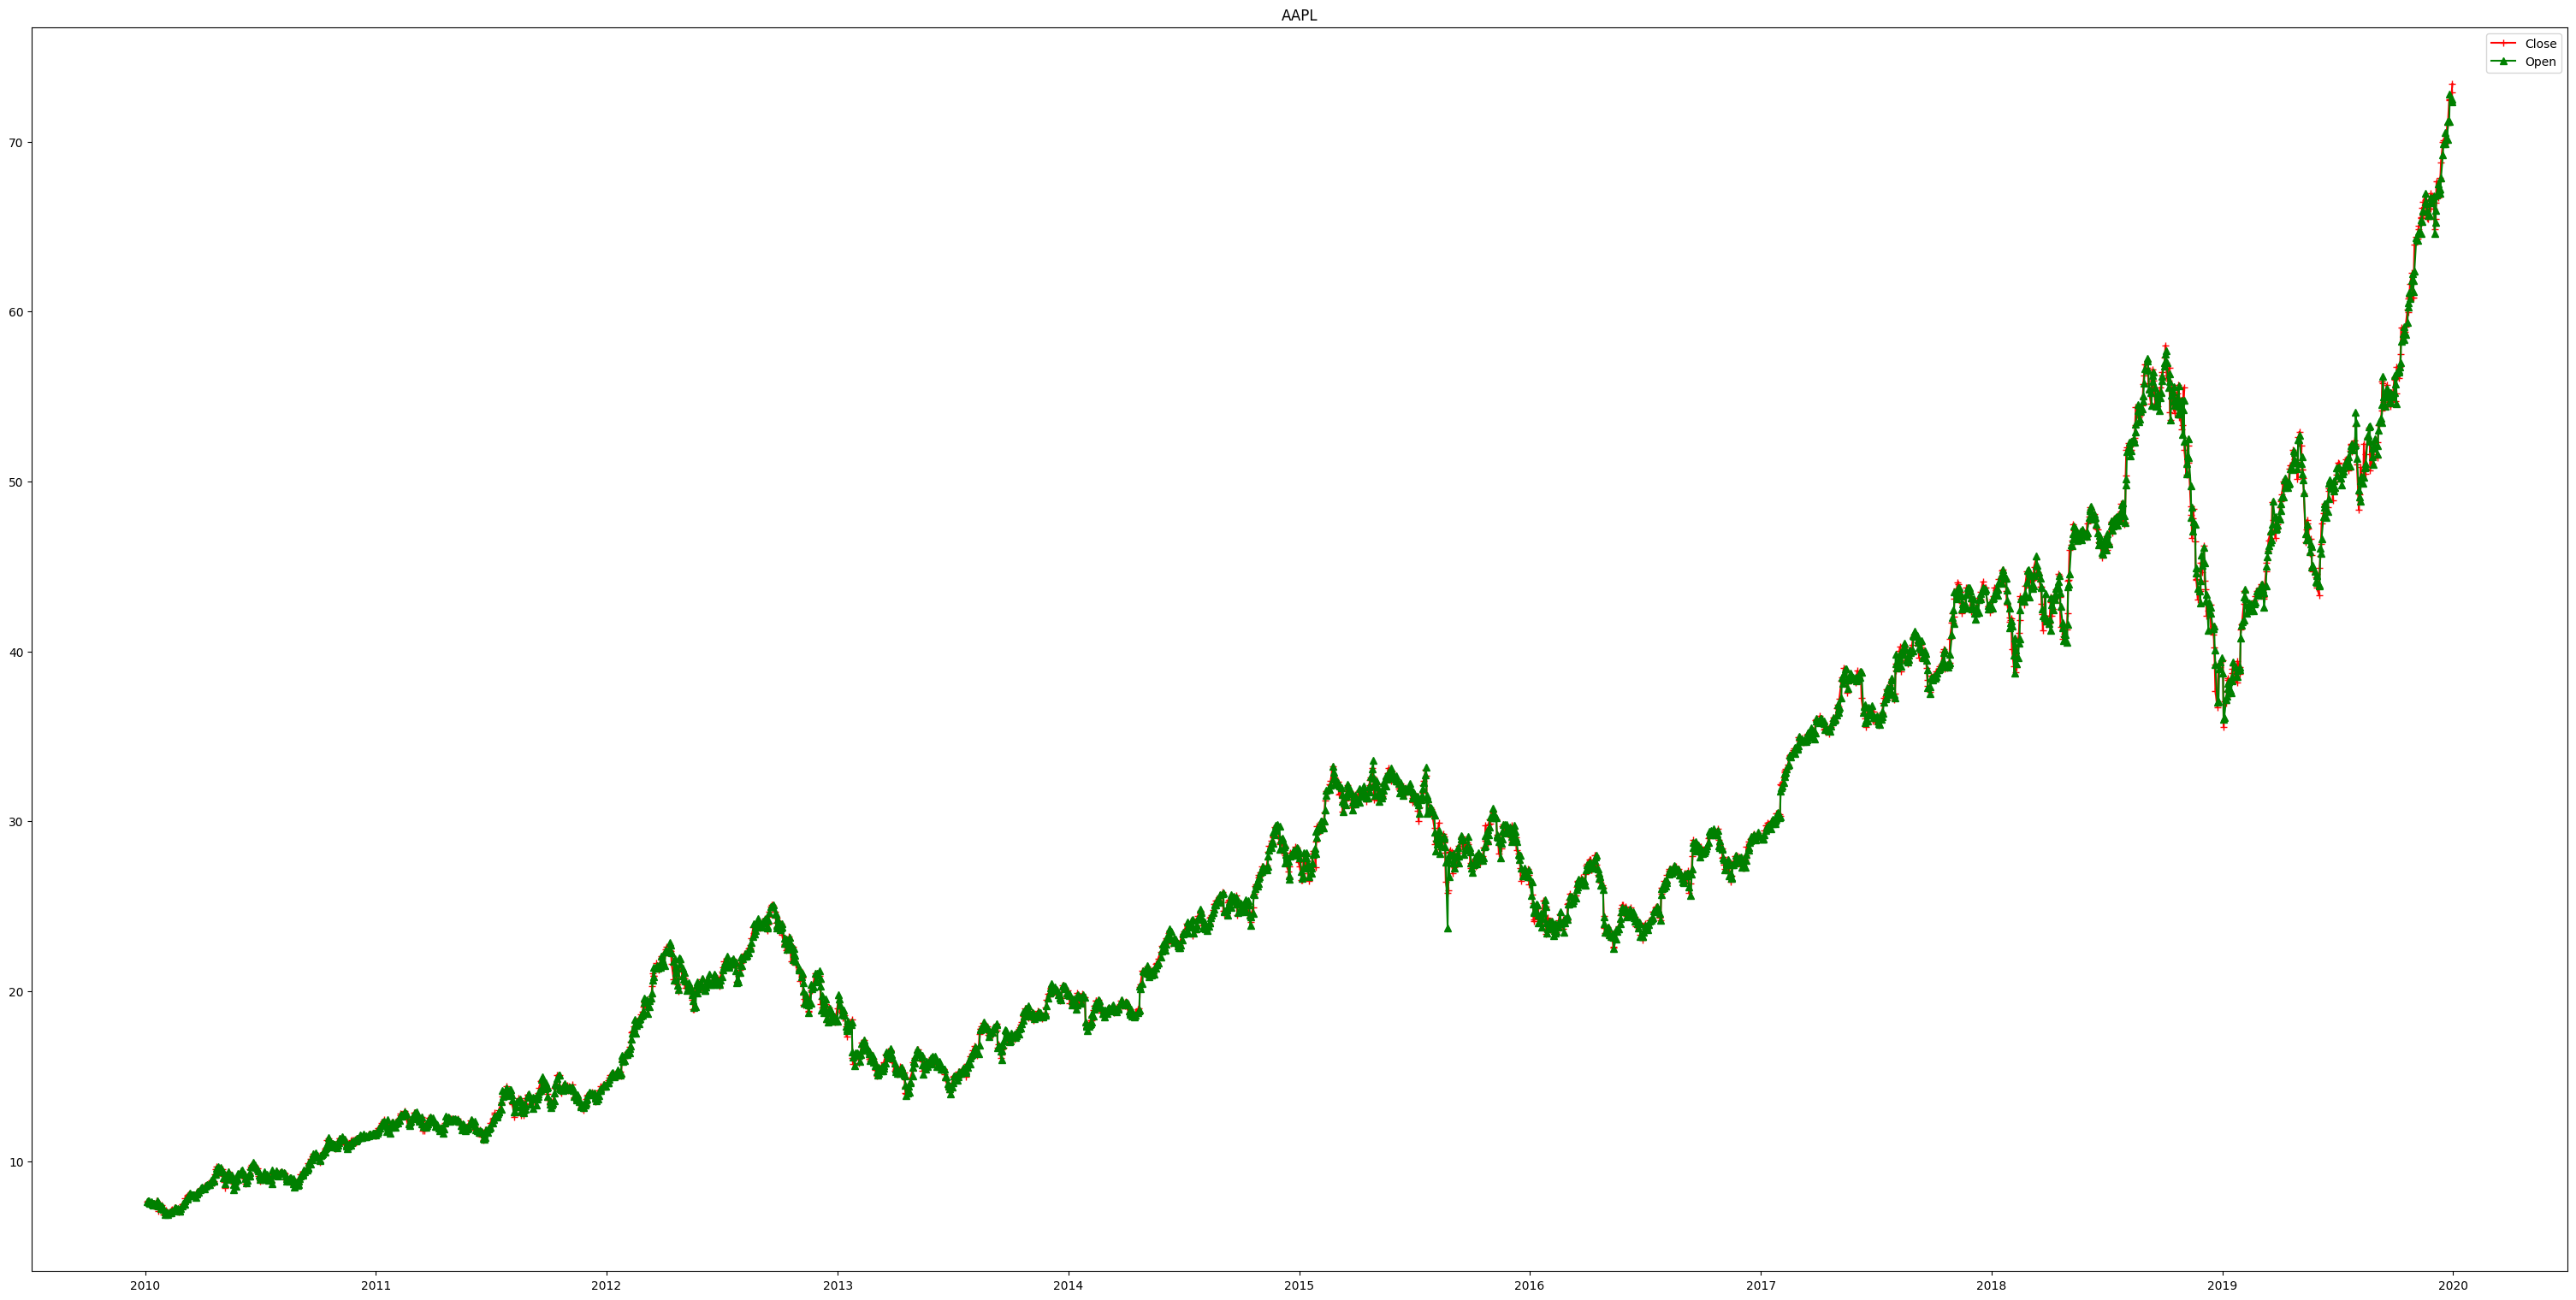

In [22]:
# date vs open
# date vs close
plt.figure(figsize=(60, 30))
plt.subplot(2, 2, 1)
plt.plot(data['Date'], data['Close'], c="r", label="Close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="Open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()


Plotting the volume of trade as a function of time...

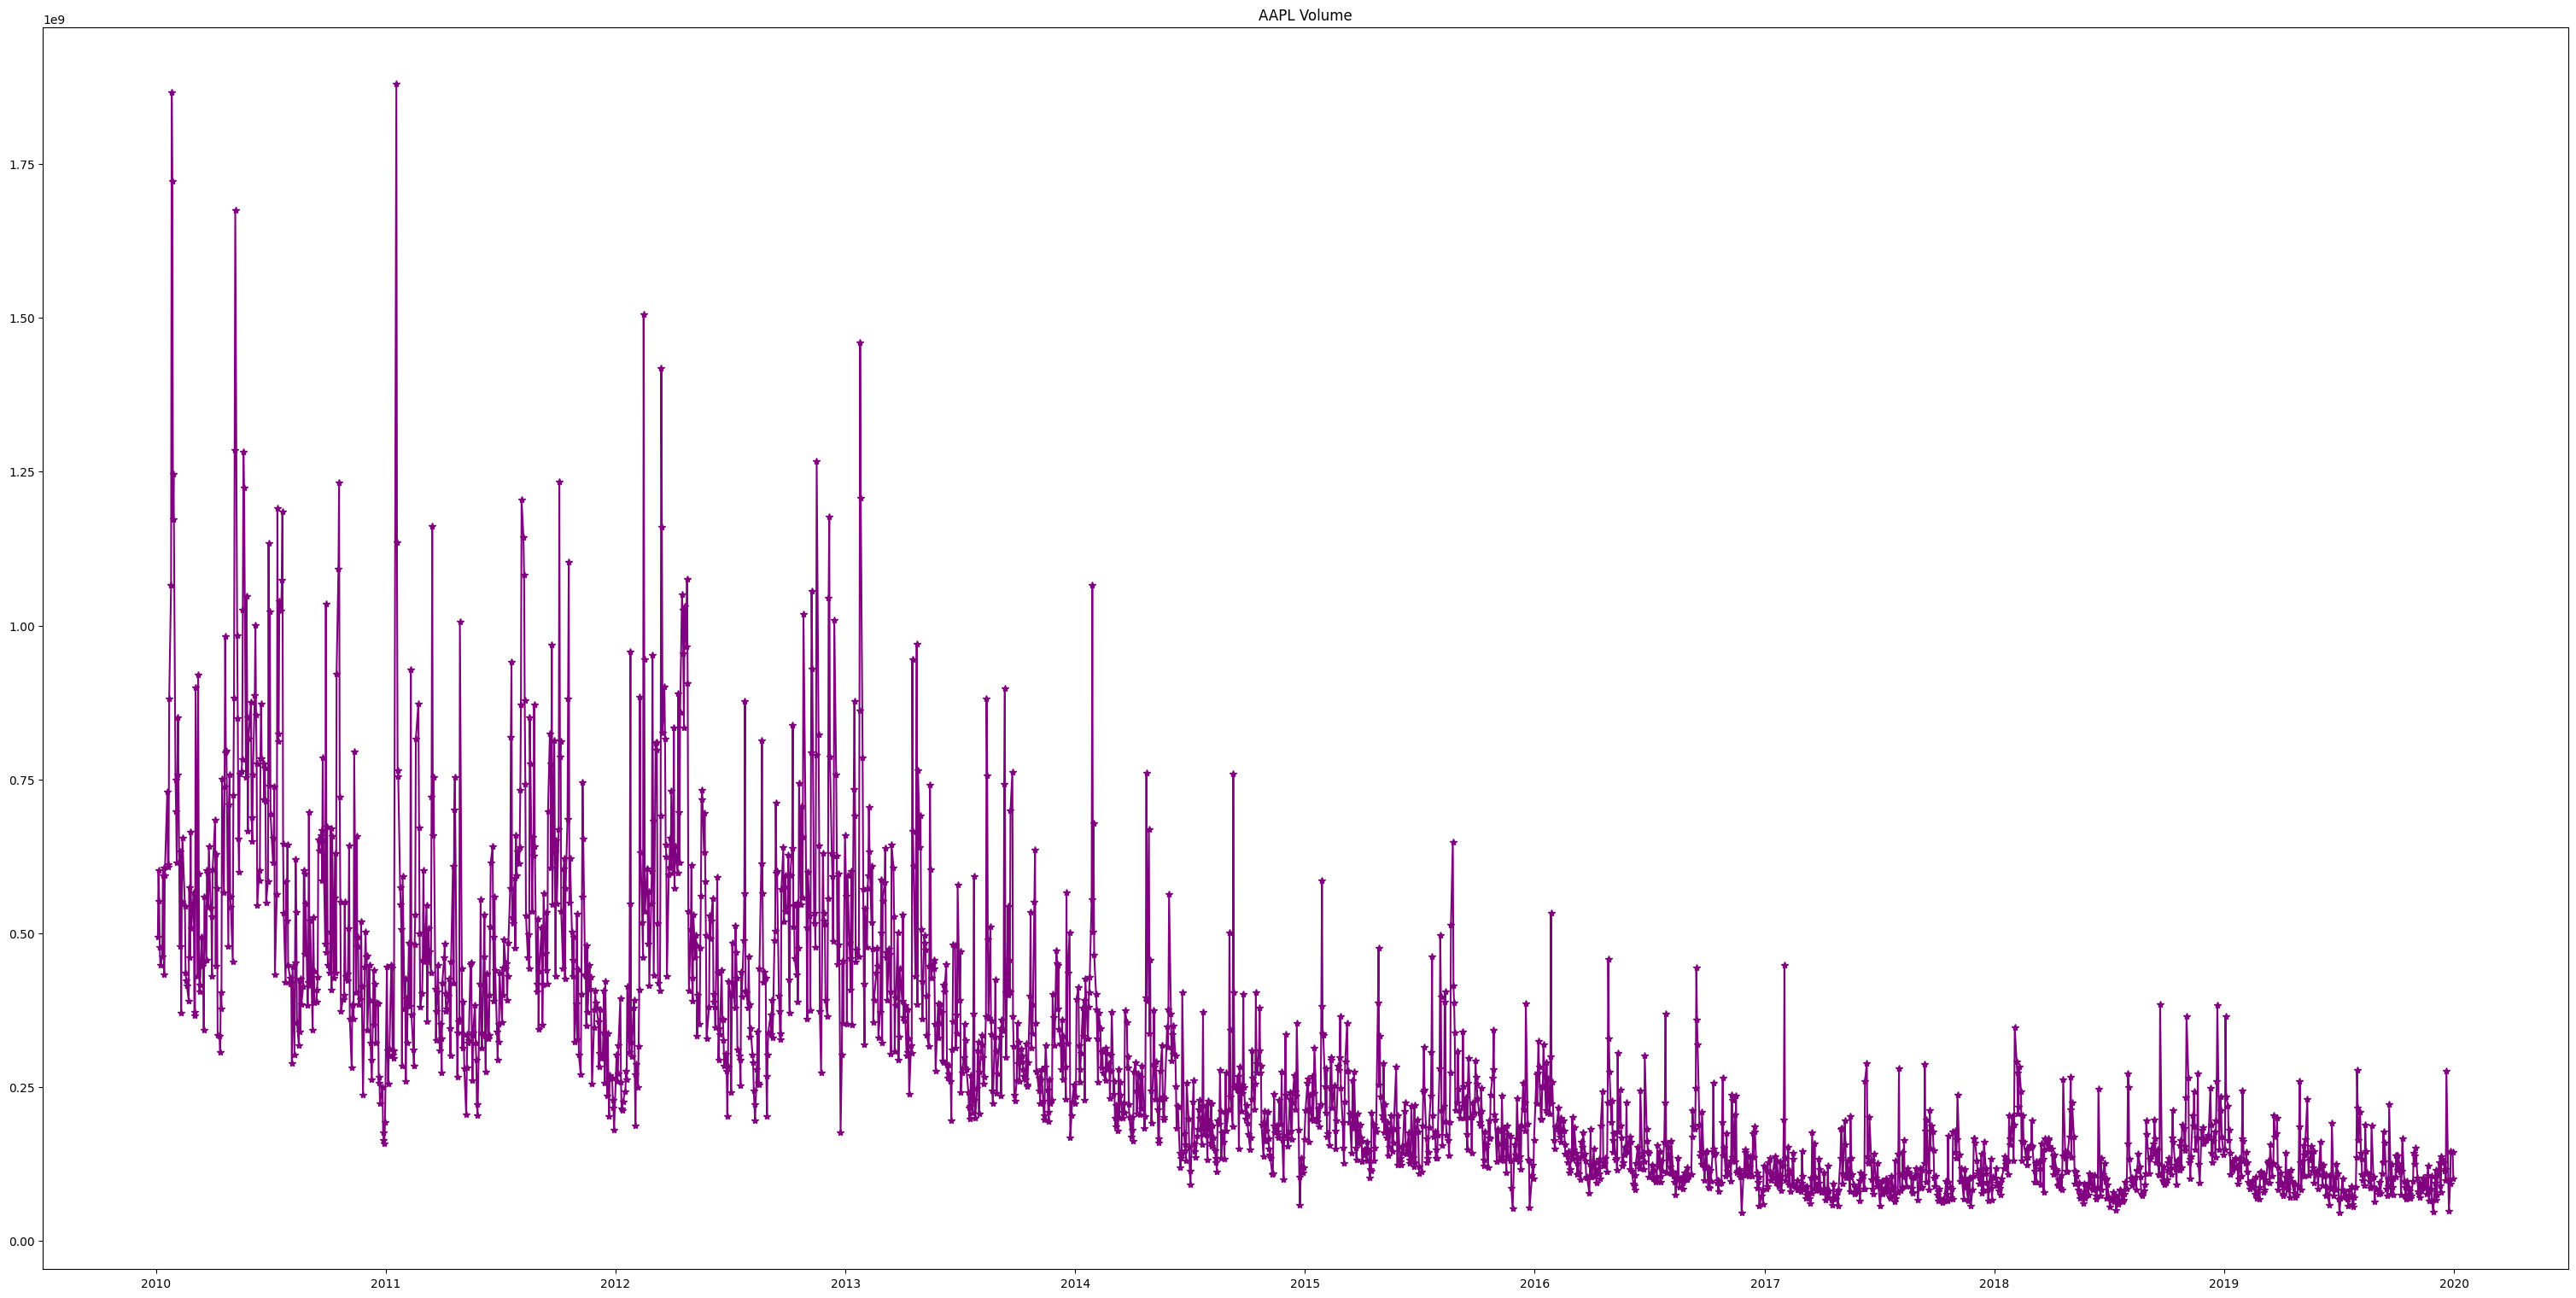

In [23]:
plt.figure(figsize=(60, 30))
plt.subplot(2, 2, 1)
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title(f"AAPL Volume")
plt.tight_layout()


Analyzing the data of AAPL trade from 2010 to 2020

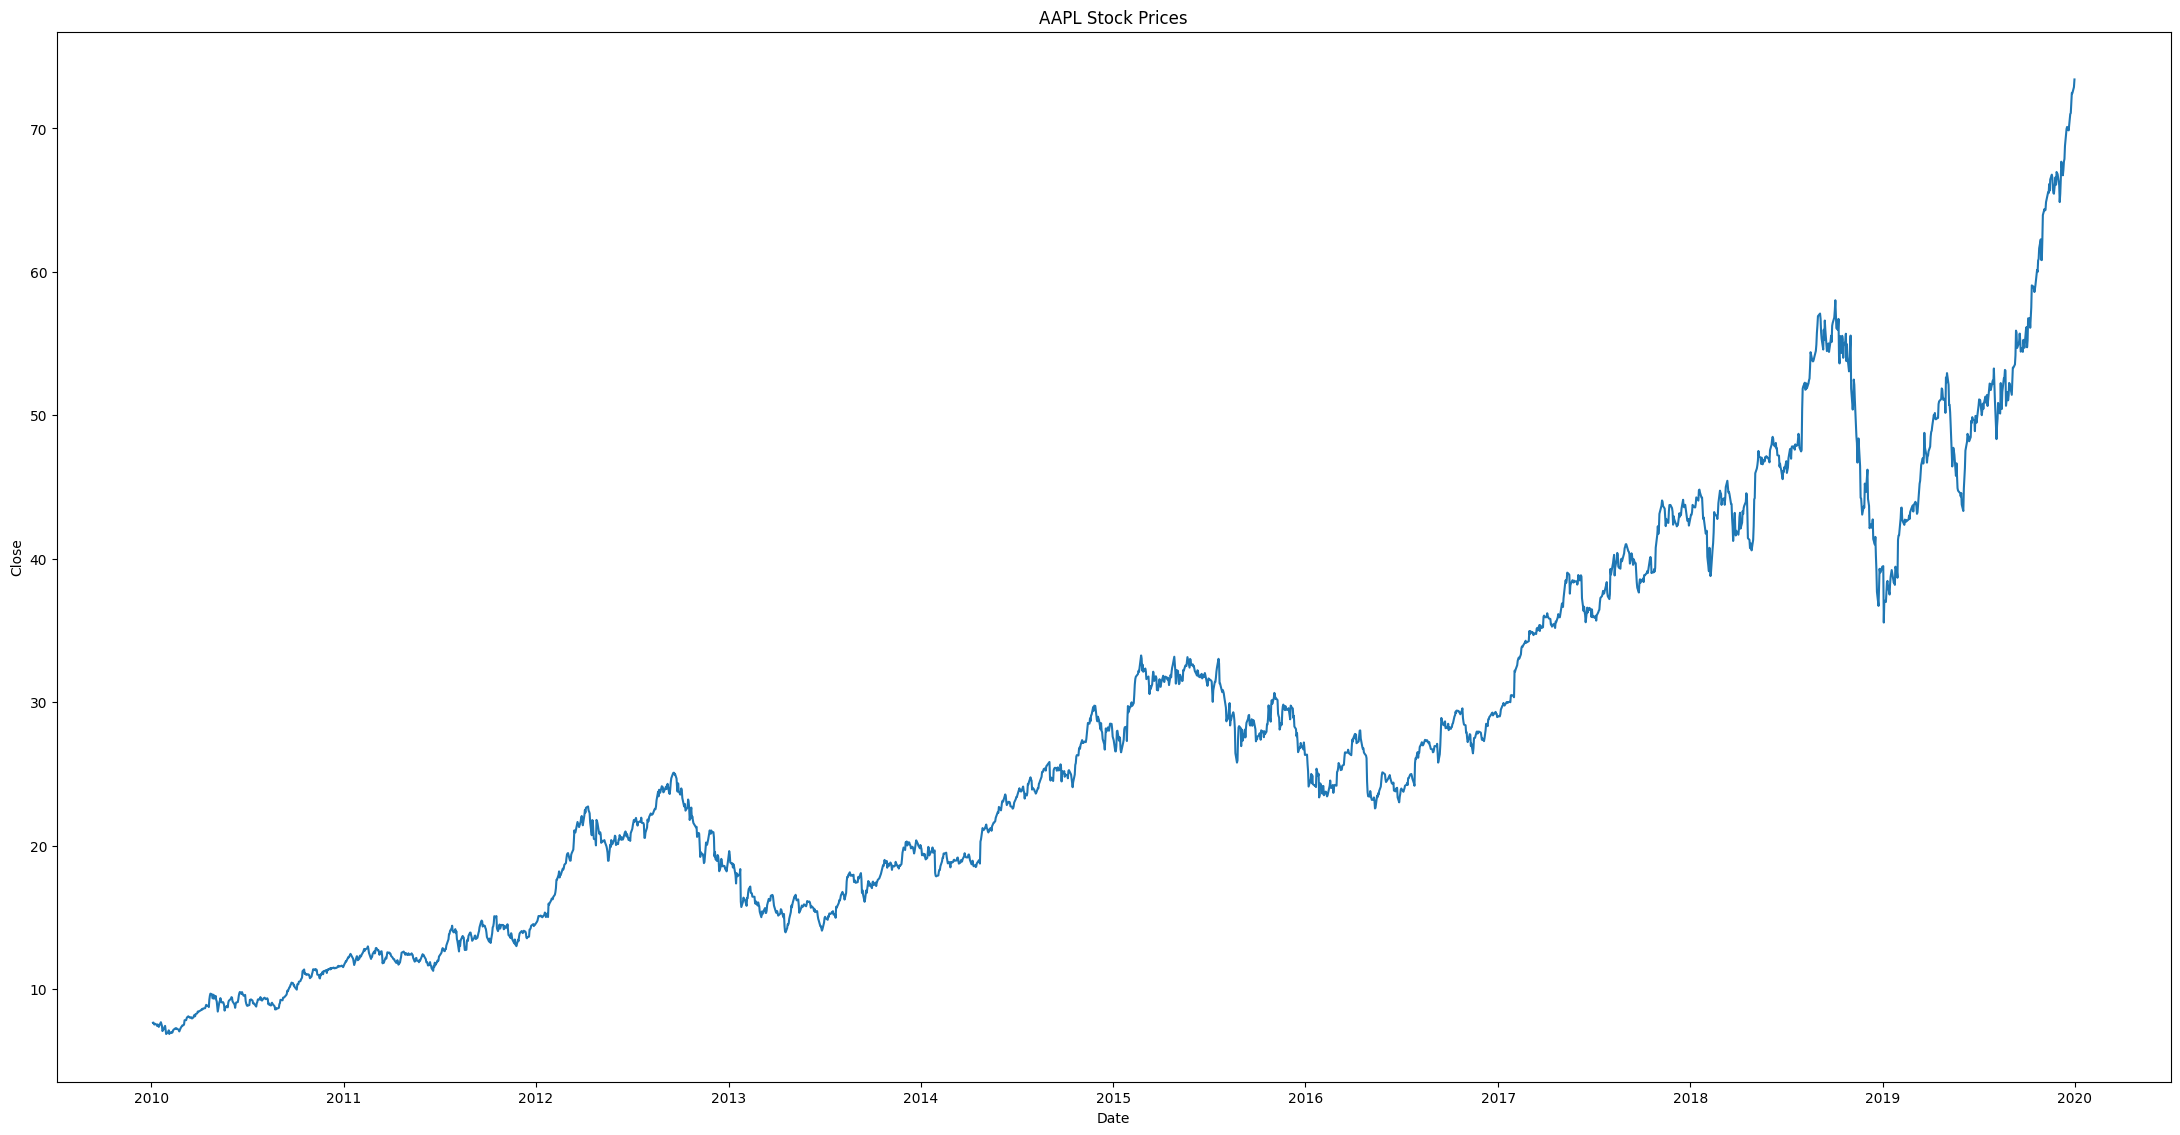

In [27]:
prediction_range = data.loc[(data['Date'] > datetime(2013,1,1)) & (data['Date']<datetime(2018,1,1))]
plt.figure(figsize=(60, 30))
plt.subplot(2, 2, 1)

plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("AAPL Stock Prices")
plt.show()


Selecting a subset of the whole data as the training data so, that we will be left with a subset of the data for the validation part as well...

In [28]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)


2391


Now we have the training data length, next applying scaling and preparing features and labels that are x_train and y_train. 

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


Using TensorFlow, we can easily create LSTM-gated RNN cells. LSTM is used in Recurrent Neural Networks for sequence models and time series data. LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. To stack multiple LSTM in TensorFlow it is mandatory to use return_sequences = True. Since our data is time series varying we apply no activation to the output layer and it remains as 1 node. 

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)


Epoch 1/10
73/73 [==============================] - 3s 25ms/step - loss: 0.0095
Epoch 2/10
73/73 [==============================] - 2s 28ms/step - loss: 0.0044
Epoch 3/10
73/73 [==============================] - 2s 26ms/step - loss: 0.0035
Epoch 4/10
73/73 [==============================] - 2s 25ms/step - loss: 0.0035
Epoch 5/10
73/73 [==============================] - 2s 25ms/step - loss: 0.0033
Epoch 6/10
73/73 [==============================] - 2s 26ms/step - loss: 0.0028
Epoch 7/10
73/73 [==============================] - 2s 29ms/step - loss: 0.0025
Epoch 8/10
73/73 [==============================] - 2s 29ms/step - loss: 0.0024
Epoch 9/10
73/73 [==============================] - 2s 25ms/step - loss: 0.0022
Epoch 10/10
73/73 [==============================] - 2s 26ms/step - loss: 0.0020


For predicting we require testing data, so we first create the testing data and then proceed with the model prediction...

In [34]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


4/4 [==============================] - 0s 7ms/step
MSE 11.902850428605783
RMSE 3.450050786380656


Visualizing the final results...

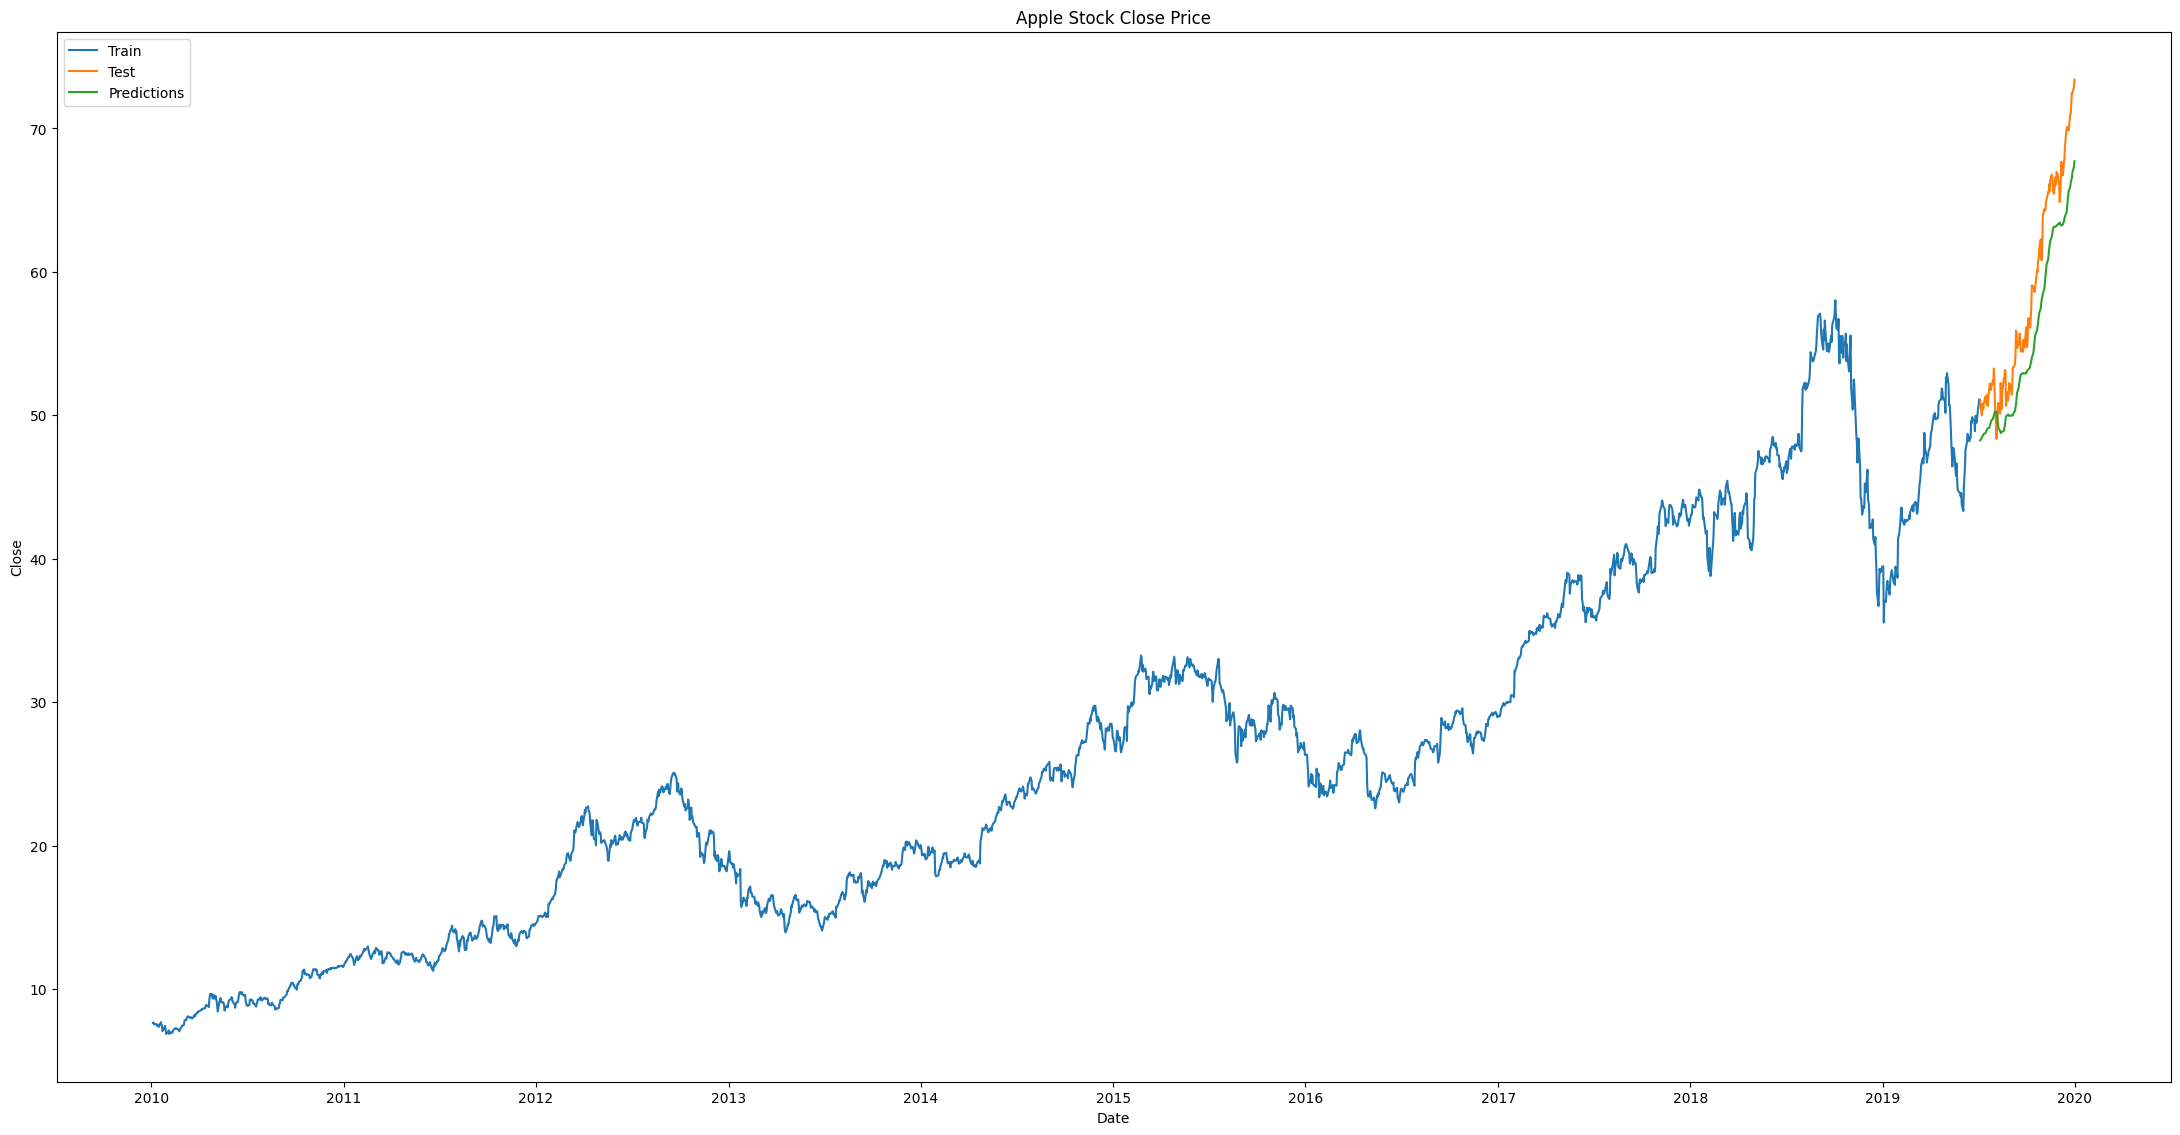

In [44]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(60, 30))
plt.subplot(2, 2, 1)
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
